# Deep neural network-based models for predicting mRNA editing (CNN) in Trachurus trachurus 

Convolutional Neural Network

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
from keras import backend as K
from keras.models import Sequential


In [2]:
########################################
# PARAMS
########################################
fname      = 'ttr_DL_Pad_W50_BALANCED_1_1_CODED2CH.csv'
separator_char=';'
categories=[['A','G','C','T'],['s','d','h','i','b']]
padding=True
ptrain     = 0.7
trace_level = 1
model_name = 'TFM_CNN_TT'
num_channels=256
kernel_width  = 9
n_epochs=40
batch_size=32
categories_size=20
cnn_dropout=0.4
random_seed=2022
########################################

We can run this notebook in two environments:
+ Googlr Colab Pro (Cloud)
+ Jupyter Lab (Locally)

In [3]:
#CHECK GOOGLE COLAB
GOOGLE_COLAB=False
if 'google.colab' in str(get_ipython()):
  GOOGLE_COLAB=True  
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Not running on CoLab


Checking if GPU is available and GPU characteristics.

In [4]:
#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Num GPUs Available: {}'.format(len(tf.config.list_physical_devices('GPU'))))
  print('Found GPU at: {}'.format(device_name))
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
     print('Not connected to a GPU')
  else:
     print(gpu_info)

Num GPUs Available: 1
Found GPU at: /device:GPU:0
Mon Oct 17 19:25:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0    N/A /  N/A |    164MiB /  2048MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

In [5]:
if padding==True:
    categories_size=categories_size+1

if GOOGLE_COLAB==False:
    data_dir = '../../data/datasets/ALL_TT/W50'
    models_dir = './SAVED_MODELS'

else:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    #set the path to find RNAEd module
    sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')    
    data_dir  = '/content/drive/MyDrive/DATASETS/ALL_TT/W50'
    models_dir= '/content/drive/MyDrive/MODELS'

In [6]:
from rnaed import DataGenerator,DataEncoding
encoding=DataEncoding(categories,padding=padding,pad_char="*")
n_ch,cat=encoding.getChannels()
print("Number of channels: {} /categories: {}".format(n_ch,cat))
encoding.print_LUT_TupleToInteger()
categories_size=encoding.getNumCodes()
print("Number of codes or categories size: {}".format(categories_size))

Number of channels: 2 /categories: [['A', 'G', 'C', 'T'], ['s', 'd', 'h', 'i', 'b']]
Number of codes=21
('A', 's') / 0
('A', 'd') / 1
('A', 'h') / 2
('A', 'i') / 3
('A', 'b') / 4
('G', 's') / 5
('G', 'd') / 6
('G', 'h') / 7
('G', 'i') / 8
('G', 'b') / 9
('C', 's') / 10
('C', 'd') / 11
('C', 'h') / 12
('C', 'i') / 13
('C', 'b') / 14
('T', 's') / 15
('T', 'd') / 16
('T', 'h') / 17
('T', 'i') / 18
('T', 'b') / 19
('*', '*') / 20
Number of codes or categories size: 21


In [7]:
#We can save best model and last model
best_model = 'best_model_'+model_name+'.h5'
last_model =  model_name+'.h5'
lastmodelfile = os.path.join(models_dir, last_model)
print("LAST MODEL FILE: {}".format(lastmodelfile))
bestmodelfile = os.path.join(models_dir, best_model)
print("BEST MODEL FILE: {}".format(bestmodelfile))
datafile = os.path.join(data_dir, fname)    

LAST MODEL FILE: ./SAVED_MODELS\TFM_CNN_TT.h5
BEST MODEL FILE: ./SAVED_MODELS\best_model_TFM_CNN_TT.h5


We read the data.

In [8]:
print("DATASET: {}".format(datafile))
dataraw = pd.read_csv(datafile,sep=separator_char)
print("shape dataraw={}".format(dataraw.shape))

DATASET: ../../data/datasets/ALL_TT/W50\ttr_DL_Pad_W50_BALANCED_1_1_CODED2CH.csv
shape dataraw=(283012, 104)


We will divide the data into: train, validation and test.
The three datastes should be well balanced.

In [9]:
X=dataraw.iloc[:,3:]
Y=dataraw['EDITING']
print(X.head)

<bound method NDFrame.head of         P1  P2  P3  P4  P5  P6  P7  P8  P9  P10  ...  P92  P93  P94  P95  P96  \
0        2  12  17  17   7  12  12  17   7    7  ...   15   10   15   10   15   
1       11   3  11  16   6  11  11   1  11   11  ...    2   17    6    6   11   
2        8  16   6  13  18  18   3  16  16   11  ...   16   11    1   11    1   
3       18  18   6  16   1  16   1  11  11    5  ...    2   17    7   17   17   
4       17  17  17   2   2   7  17   2  17    7  ...    5   10    0   10    0   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
283007  10  16   6  16  11  16  11  16  11   16  ...   11    1   15    0    6   
283008  11   1  16   5   6  11  16   6   1    1  ...   12   12    2    6   11   
283009   6   6  18  11  16  11  11   8   3    8  ...    2   12    2    2   17   
283010   1   1  11  11  16   6  16   3   8   13  ...   11   16   16   16   16   
283011  17   7   2   2  17   2   2   7   7    2  ...    2   17    2    2    6  

In [10]:
# Train and Validation+Test
x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, test_size=1-ptrain, random_state=random_seed)
#Validation and test: 0.5/0.5
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=random_seed)

print("x_train:{} y_train:{}".format(x_train.shape,y_train.shape))
print("x_val: {} y_val: {}".format(x_val.shape,y_val.shape))
print("x_test: {} y_test: {}".format(x_test.shape,y_test.shape))
print("TRAIN LABELS:")
print(y_train.value_counts())
print("VALIDATION LABELS:")
print(y_val.value_counts())
print("TEST LABELS:")
print(y_test.value_counts())

x_train:(198108, 101) y_train:(198108,)
x_val: (42452, 101) y_val: (42452,)
x_test: (42452, 101) y_test: (42452,)
TRAIN LABELS:
1    99118
0    98990
Name: EDITING, dtype: int64
VALIDATION LABELS:
1    21271
0    21181
Name: EDITING, dtype: int64
TEST LABELS:
0    21335
1    21117
Name: EDITING, dtype: int64


We instantiate 3 DataGenerator objects that convert from integer to one-hot

In [11]:
#DataGenerator converts on the fly from raw data to one-hot
num_nucleosides = x_train.shape[1]
num_tokens = categories_size

training_generator   = DataGenerator(x_train, y_train, batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
validation_generator = DataGenerator(x_val,   y_val,   batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
test_generator       = DataGenerator(x_test,  y_test,  batch_size=1,seq_size=num_nucleosides, categories_size=categories_size, shuffle=False )

## Model defined from the scratch

In [12]:
#MODELOS REDES NEURONALES CNN


model = Sequential()
#===============================================================
model.add(layers.Conv1D(num_channels, kernel_width, activation='relu',input_shape=(num_nucleosides, num_tokens)))
model.add(layers.Dropout(cnn_dropout))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(num_channels,6, activation='relu'))
model.add(layers.Dropout(cnn_dropout))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(num_channels,2, activation='relu'))
model.add(layers.Dropout(cnn_dropout))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))
#===============================================================
#Mostramos el modelo
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 93, 256)           48640     
                                                                 
 dropout (Dropout)           (None, 93, 256)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 256)           393472    
                                                                 
 dropout_1 (Dropout)         (None, 13, 256)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 256)           0         
 1D)                                                    

In [13]:
#Compilation reset all weights
model.compile(optimizer=keras.optimizers.Adam(),
              loss     =keras.losses.BinaryCrossentropy(),
              metrics  =[keras.metrics.BinaryAccuracy()])

Recover last model, best model or generate a new model

In [14]:
#Load the trained model from disk
import os.path

best_model_accuracy =0
last_model_accuracy =0


In [15]:
if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)
    print("Testing best model file: {}".format(bestmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    best_model_accuracy = results[1]
    print("best model accuracy: {}".format(best_model_accuracy))    

In [16]:
if os.path.exists(lastmodelfile):
    model = tf.keras.models.load_model(lastmodelfile)
    print("Testing last complete model file: {}".format(lastmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    last_model_accuracy = results[1]
    print("last model accuracy: {}".format(last_model_accuracy))           


In [17]:
if best_model_accuracy >= last_model_accuracy and best_model_accuracy != 0:
   model = tf.keras.models.load_model(bestmodelfile)
   print("Selected best model saved: {}".format(bestmodelfile))
else:
  if last_model_accuracy > best_model_accuracy:
     print("Selected last model saved: {}".format(lastmodelfile))
  else:
     print("Selected new untrained model")

# Show the model architecture
model.summary()

Selected new untrained model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 93, 256)           48640     
                                                                 
 dropout (Dropout)           (None, 93, 256)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 256)           393472    
                                                                 
 dropout_1 (Dropout)         (None, 13, 256)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 256)           0         
 1D)                       

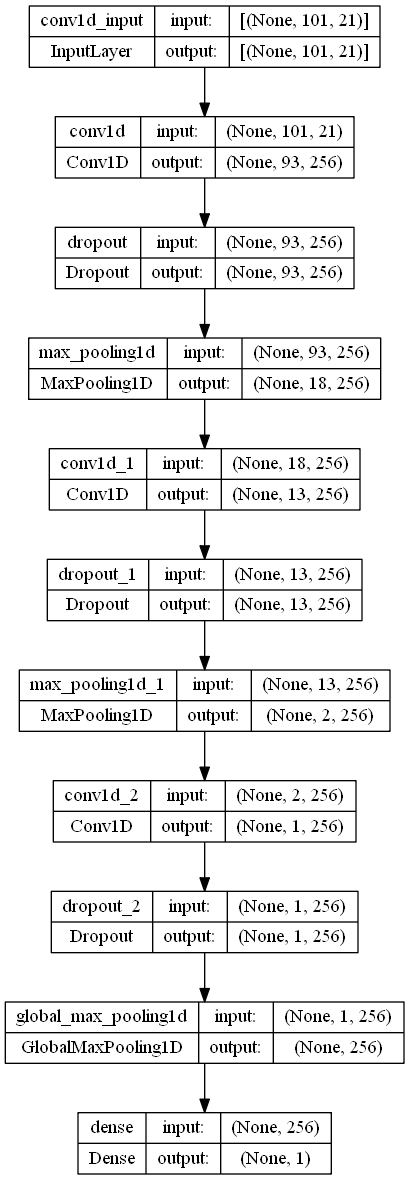

In [18]:
keras.utils.plot_model(model, show_shapes=True)

In [19]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint(bestmodelfile, 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='auto', 
                             save_freq='epoch')

callback=EarlyStopping(monitor='val_loss', 
                       min_delta=0, 
                       patience=3, 
                       verbose=1, 
                       mode='auto',
                       baseline=None, 
                       restore_best_weights=True)

In [ ]:
with tf.device(device_name):#Use GPU if available
    history=model.fit(training_generator,epochs=n_epochs,
                      validation_data=validation_generator,
                      callbacks=[checkpoint,callback],verbose=trace_level)

Epoch 1/40
2695/6190 [============>.................] - ETA: 8:12 - loss: 0.6894 - binary_accuracy: 0.5330

In [21]:
#We always save the last model.
#Last model can be triggered by early stopping
n_epochs_trained = len(history.history['loss'])
print("Trained epochs: {} of {}".format(n_epochs_trained,n_epochs))
model.save(lastmodelfile)    

Trained epochs: 20 of 40


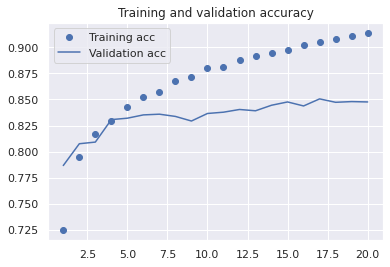

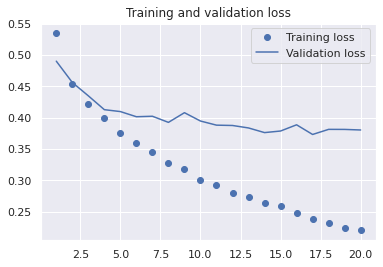

In [22]:
#PLOT ACCURACY AND LOSS

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We recover the best model saved.

In [23]:
if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)

We evaluate the best model on validation data.

In [24]:
#EVALUATE VALIDATION DATASET
print("Evaluate models on validation data")
results_model = model.evaluate(validation_generator,verbose=trace_level)
print ('Accuracy on validation data:',round(results_model[1],3))
print ('Loss on validation data:',round(results_model[0],3))

Evaluate models on validation data
277/277 [==============================] - 26s 93ms/step - loss: 0.3730 - binary_accuracy: 0.8507
Accuracy on validation data: 0.851
Loss on validation data: 0.373


We make predictions on test data, never used during training nor validation

In [25]:
#PREDICTIONS
print("Make predictions on test data")
model_prediction = model.predict(test_generator,verbose=trace_level)
model_prediction_binary = (model_prediction > 0.5).astype("int32")

Make predictions on test data
8895/8895 [==============================] - 42s 5ms/step


In [26]:
print(x_test.shape)
print(y_test.shape)
print(model_prediction.shape)
print(model_prediction_binary.shape)

(8895, 101)
(8895,)
(8895, 1)
(8895, 1)


In [27]:
#METRICS QUALITY CLASSIFICATION
print("MODEL "+model_name+"\n---------------------------------")
kappa = cohen_kappa_score(y_test, model_prediction_binary)
print ('Kappa:',round(kappa,3))
print(classification_report(y_test, model_prediction_binary))

MODEL TFM_CNN_MM_ALLMM
---------------------------------
Kappa: 0.702
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      4509
           1       0.87      0.82      0.84      4386

    accuracy                           0.85      8895
   macro avg       0.85      0.85      0.85      8895
weighted avg       0.85      0.85      0.85      8895



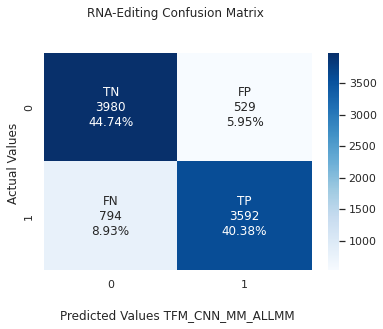

In [28]:
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
# PLOT CONFUSION MATRIX
# Tutorial: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
plt.figure()

cm = confusion_matrix(y_test,model_prediction_binary)

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('RNA-Editing Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values '+ model_name)
ax.set_ylabel('Actual Values ');
plt.show()


AUC: 0.91


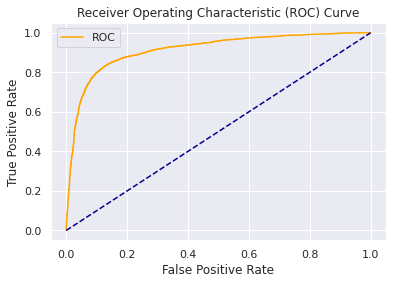

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

auc = roc_auc_score(y_test, model_prediction)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, model_prediction)
plot_roc_curve(fpr, tpr)


# RESULTS INSIGHT

In [ ]:
results_data = x_test
if 'RESULT_TYPE' not in results_data.columns:
    #insert column at position 3
    results_data.insert(3,"RESULT_TYPE", None)
    results_data.insert(4,"PROB_PRED",model_prediction)
else:
    print("RESULT_TYPE already exists in the dataframe")

results_data.head()

In [ ]:
column_index=results_data.columns.get_loc('RESULT_TYPE')
i=0
for result in model_prediction_binary:
    #print("Comparing result={} with data_y_test={}".format(result[0],data_y_test.iloc[i]))
    if   result[0]==0 and y_test.iloc[i]==0:
       typeRes ="TN"
    elif result[0]==0 and y_test.iloc[i]==1:
       typeRes="FN"
    elif result[0]==1 and y_test.iloc[i]==0:
       typeRes="FP"
    elif result[0]==1 and y_test.iloc[i]==1:
       typeRes="TP"
    results_data.iloc[i, column_index]=typeRes
    i+=1
    
results_data.head()

In [ ]:
#Save the results into a file
report_dir="./report"
results_csv_file  =model_name + "_Results.csv"
results_excel_file=model_name + "_Results.xlsx"
results_data.to_csv(os.path.join(report_dir,results_csv_file))
results_data.to_excel(os.path.join(report_dir,results_excel_file))

Now, we are going to find the record with highest probability and category TP (True Positive) as a good model of TP data,
and alternatively, the best representative of TN, using the lowest value

In [ ]:
subset_TP=results_data.loc[results_data['RESULT_TYPE'] == 'TP']
prototype_of_TP_id=subset_TP['PROB_PRED'].idxmax()
print("rowid best TP = {}".format(prototype_of_TP_id))
print(results_data.loc[prototype_of_TP_id,])

In [ ]:
subset_TN=results_data.loc[results_data['RESULT_TYPE'] == 'TN']
prototype_of_TN_id=subset_TN['PROB_PRED'].idxmin()
print("rowid best TN = {}".format(prototype_of_TN_id))
print(results_data.loc[prototype_of_TN_id,])